### 1. Data analysis

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import os
from PIL import Image
from tqdm import tqdm

# location for FOOD-101 dataset
folder_name = 'C:\\FOOD-101\\'

In [ ]:
'''
from google.colab import drive
drive.mount('/content/gdrive')
folder_name = 'gdrive/My Drive/Colab Notebooks/FOOD-101/'
'''

In [2]:
food_path = folder_name + 'food-101'
meta_path = food_path + os.sep + 'meta'
image_path = food_path + os.sep + 'images'

Uncomment the following cell to load the dataset.

In [ ]:
'''
import requests
import tarfile

archive_name = folder_name + 'food-101.tar.gz'
url = 'http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz'
chunk_size = 8192
with requests.get(url, stream=True) as r:
    r.raise_for_status()
    size = r.headers.get("Content-Length")
    chunks = int(size) // chunk_size if size else None
    with open(archive_name, 'wb') as f:
        for chunk in tqdm(r.iter_content(chunk_size=chunk_size), total=chunks):
            f.write(chunk)
with tarfile.open(name=archive_name) as tar:
    for member in tqdm(tar.getmembers(), total=len(tar.getmembers())):
        tar.extract(member=member, path=folder_name)
'''

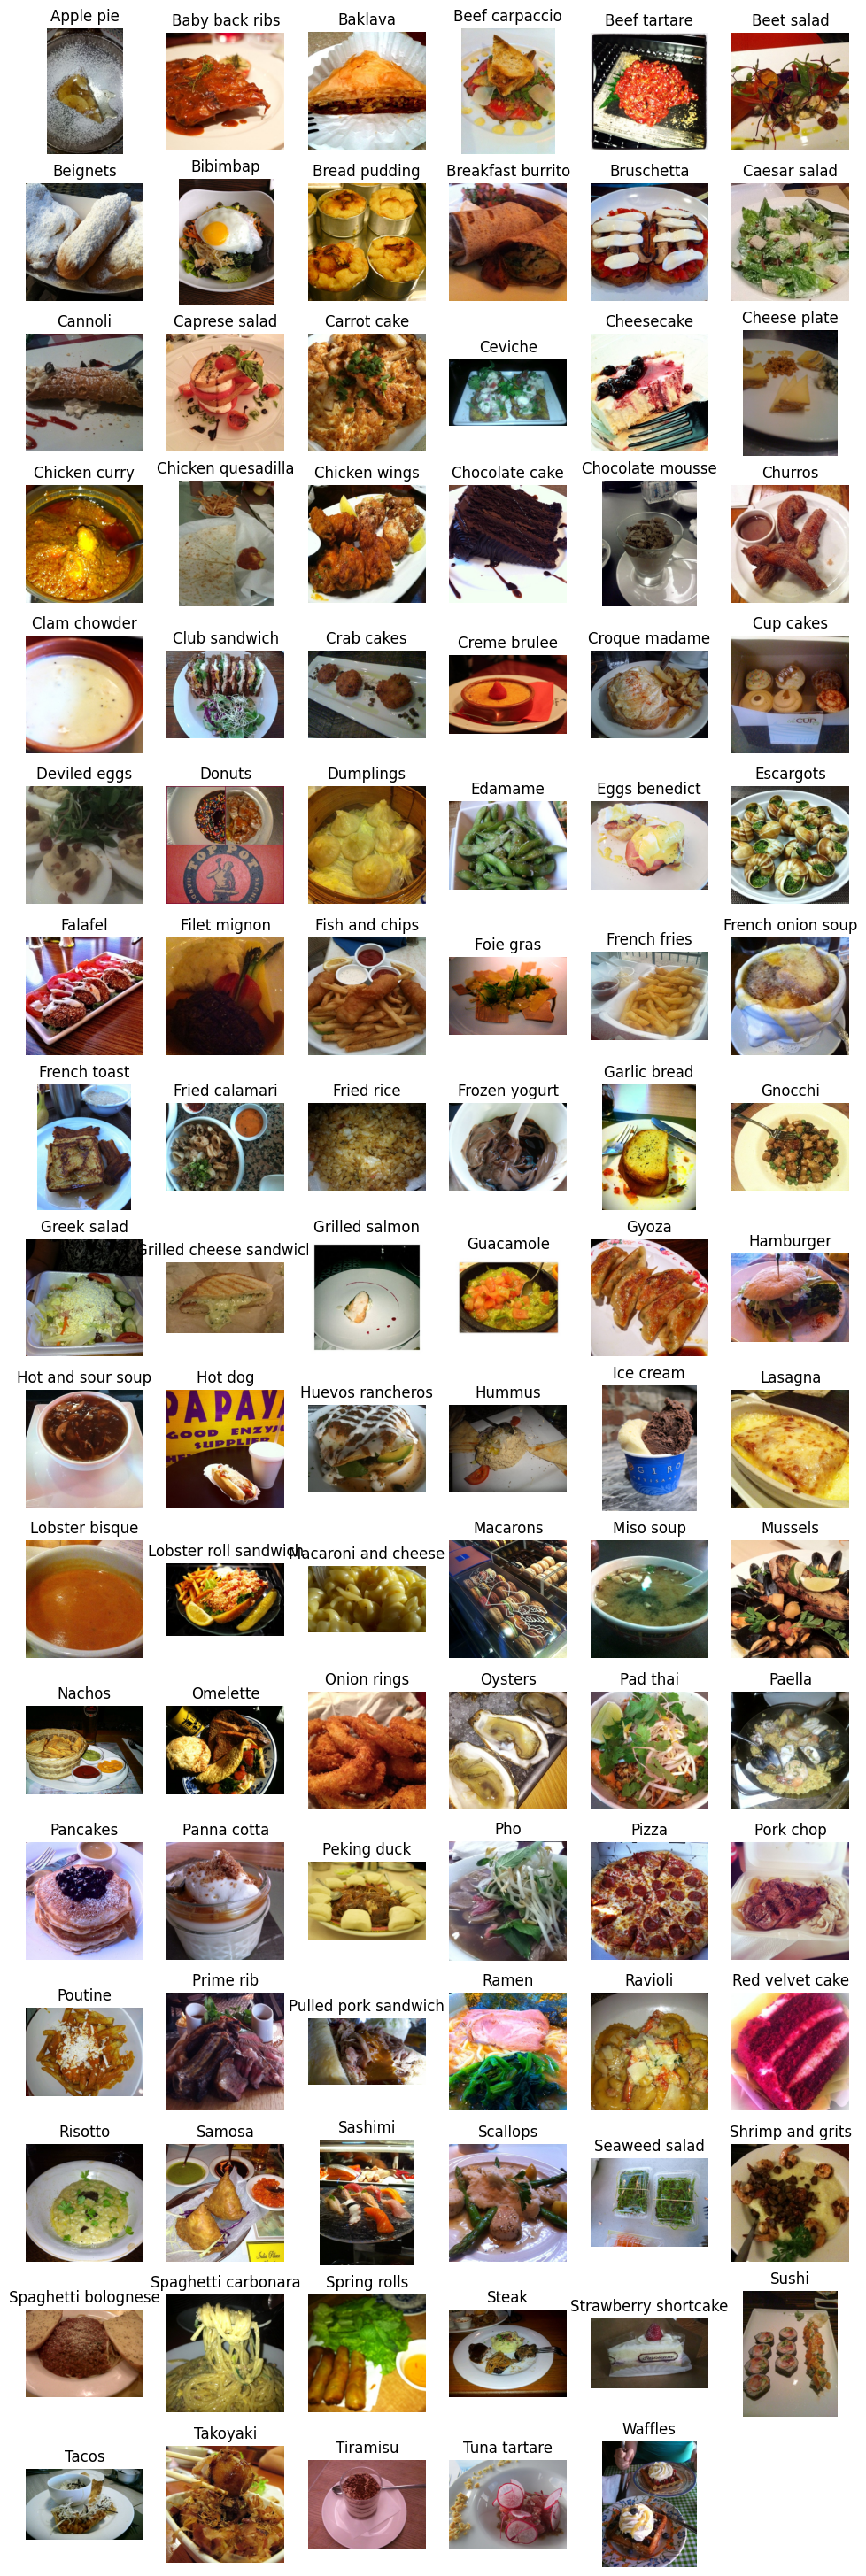

In [3]:
# I display one image of each class
with open(meta_path + os.sep + 'classes.txt') as f:
    classes = [cls.rstrip() for cls in f.readlines()]
with open(meta_path + os.sep + 'labels.txt') as f:
    labels = [lbl.rstrip() for lbl in f.readlines()]
rows, columns = (17, 6)
_, axes = plt.subplots(rows, columns, figsize=(12, 12), gridspec_kw=dict(top=2.5))
for _, ax in np.ndenumerate(axes):
    ax.axis('off')
distrib = dict()
total_number = 0
for i in range(len(classes)):
    images = os.listdir(image_path + os.sep + classes[i])
    class_number = len(images)
    distrib[labels[i]] = class_number
    total_number += class_number
    image_file = image_path + os.sep + classes[i] + os.sep + images[0]
    row = i // columns
    column = i % columns
    pil_im = Image.open(image_file, 'r')
    axes[row][column].imshow(np.asarray(pil_im))
    axes[row][column].title.set_text(labels[i])

Total number = 101000


Text(0, 0.5, 'Number of images per class')

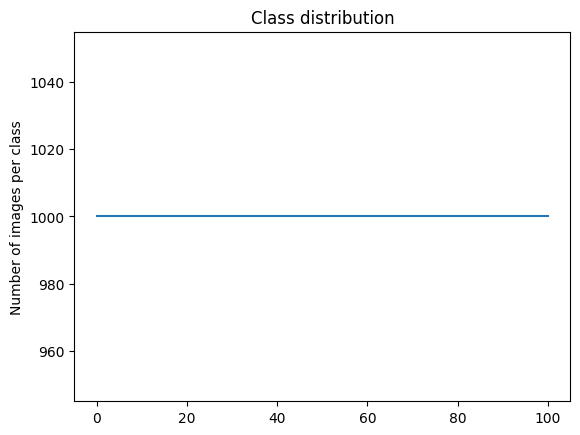

In [4]:
print(f"Total number = {total_number}")
plt.plot(distrib.values())
plt.title('Class distribution')
plt.ylabel('Number of images per class')

Each of the 101 classes has 1000 images, i.e. the distribution of images by classes is uniform.

When splitting the data into training and validation sets, I keep the class distribution uniform so that there are enough examples of each class during training.

In [5]:
import json
from sklearn.model_selection import train_test_split

In [6]:
with open(meta_path + os.sep + 'train.json') as f:
    train = json.load(f)
current_train = dict()
current_val = dict()
for cls, images in train.items():
    X = images
    y = [cls] * len(images)
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)
    current_train[cls] = X_train
    current_val[cls] = X_val

### 2. ResNet Fine-tuning

In [7]:
from sklearn.metrics import accuracy_score
import torch
import torchvision
from torchvision.datasets import Food101
from torchvision.models import resnet50, ResNet50_Weights
from typing import Optional, Callable

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [9]:
def seed_everything(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [10]:
seed_everything(42)
resnet = resnet50(weights = ResNet50_Weights.DEFAULT)
resnet.fc = torch.nn.Linear(resnet.fc.in_features, len(classes))
torch.nn.init.xavier_uniform_(resnet.fc.weight)
resnet = resnet.to(device)

The Food101 class does not support a validation dataset, so I wrote a simple wrapper for it.

In [11]:
class Food101WithValid(Food101):
    def __init__(
            self,
            root: str,
            metadata,
            transform: Optional[Callable] = None,
            target_transform: Optional[Callable] = None,
    ) -> None:
        super().__init__(root, transform=transform, target_transform=target_transform)
        self._labels = []
        self._image_files = []
        for class_label, im_rel_paths in metadata.items():
            self._labels += [self.class_to_idx[class_label]] * len(im_rel_paths)
            self._image_files += [
                self._images_folder.joinpath(*f"{im_rel_path}.jpg".split("/")) for im_rel_path in im_rel_paths
            ]

In [12]:
mean = torch.tensor([0.5182, 0.4143, 0.3116])
stdev = torch.tensor([0.2871, 0.2783, 0.2712])

When changing the image cropping strategy, you need to uncomment the next cell to recalculate the statistics.

In [ ]:
'''
pre_transform = torchvision.transforms.Compose([
    torchvision.transforms.CenterCrop(448),
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor()
])
train_dataset = Food101WithValid(root=folder_name, metadata=current_train, transform=pre_transform)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=512, shuffle=False, pin_memory=True)
means = []
stdevs = []
for X, _ in tqdm(train_dataloader):
    # Dimensions 0,2,3 are respectively the batch, height and width dimensions
    means.append(X.mean(dim=(0,2,3)))
    stdevs.append(X.std(dim=(0,2,3)))
mean = torch.stack(means, dim=0).mean(dim=0)
stdev = torch.stack(stdevs, dim=0).mean(dim=0)
print(f"mean = {mean}, stdev = {stdev}")
'''

I use the standard image data augmentation policy to combat overfitting.

In [13]:
transform_train = torchvision.transforms.Compose([
    torchvision.transforms.CenterCrop(448),
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.AutoAugment(policy=torchvision.transforms.AutoAugmentPolicy.IMAGENET),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean, stdev)
])
transform_valid = torchvision.transforms.Compose([
    torchvision.transforms.CenterCrop(448),
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean, stdev)
])
train_dataset = Food101WithValid(root=folder_name, metadata=current_train, transform=transform_train)
valid_dataset = Food101WithValid(root=folder_name, metadata=current_val, transform=transform_valid)

I used some ideas from [Kaggle](https://www.kaggle.com/code/francescolorenzo/96-fine-tuning-resnet34-with-pytorch/notebook)

In [14]:
# Maximum value for 8 GB VRAM
batch_size = 32
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=2 * batch_size, shuffle=False, pin_memory=True)

In [15]:
# Computing Loss and Accuracy in Model Validation
def test(net, test_dataloader, criterion, device):
    net.eval()
    valid_loss = torch.tensor(0., device=device)
    y_true = []
    y_pred = []
    with torch.no_grad():
        for X, y in tqdm(test_dataloader):
            X = X.to(device)
            y = y.to(device)
            preds = net(X)
            loss = criterion(preds, y)
            valid_loss += loss * test_dataloader.batch_size
            y_true.append(y)
            y_pred.append(torch.argmax(preds, dim=1))
    accuracy = 100 * accuracy_score(torch.cat(y_true).cpu().numpy(), torch.cat(y_pred).cpu().numpy())
    return valid_loss / len(test_dataloader.dataset), accuracy

In [ ]:
# Loading a model from disk
def load_model_state(net, optimizer, checkpoint_path):
    epoch = 0
    total_valid_accuracy = 0
    if os.path.isfile(checkpoint_path):
        with open(checkpoint_path, 'rb') as f:
            checkpoint = torch.load(f)
            epoch = checkpoint['epoch']
            total_valid_accuracy = checkpoint['total_valid_accuracy']
            net.load_state_dict(checkpoint['state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer'])
    return epoch, total_valid_accuracy

I did not limit the training to the number of epochs, I use the early stopping approach. Training stops if the prediction accuracy stops growing on the validation set or the prediction accuracy on the training set becomes greater than on the validation set, which is a sign of model overfitting. However, I take a conservative approach to avoid overestimating the model by loading the previous epoch model from disk.

In [ ]:
def train(net, train_dataloader, valid_dataloader, criterion, optimizer, path, device='cpu'):
    if path[-1] != os.sep:
        path = path + os.sep
    checkpoint_path = path + 'checkpoint.pth'
    checkpoint_backup = checkpoint_path + '_bak'
    if os.path.isfile(checkpoint_backup):
        print("A previous save of the model was not successful.")
        return
    epoch, total_valid_accuracy = load_model_state(net, optimizer, checkpoint_path)
    train_accuracy = []
    valid_accuracy = []
    accuracy_history_filename = path + 'accuracy'
    if os.path.isfile(accuracy_history_filename):
        with open(accuracy_history_filename) as f:
            accuracy_history = json.load(f)
        train_accuracy = accuracy_history['train']
        valid_accuracy = accuracy_history['valid']

    while True:
        seed_everything(42)
        epoch += 1
        print(f"Epoch {epoch}")

        net.train()
        train_loss = torch.tensor(0., device=device)
        y_true = []
        y_pred = []
        for X, y in tqdm(train_dataloader):
            X = X.to(device)
            y = y.to(device)
            preds = net(X)
            loss = criterion(preds, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            with torch.no_grad():
                train_loss += loss * train_dataloader.batch_size
                y_true.append(y)
                y_pred.append(torch.argmax(preds, dim=1))

        total_train_loss = train_loss / len(train_dataloader.dataset)
        total_train_accuracy = 100 * accuracy_score(torch.cat(y_true).cpu().numpy(), torch.cat(y_pred).cpu().numpy())
        print(f'Train loss: {total_train_loss:.2f}')
        print(f'Train accuracy: {total_train_accuracy:.2f}%')

        total_valid_loss, total_valid_accuracy_new = test(net, valid_dataloader, criterion, device)
        print(f'Valid loss: {total_valid_loss:.2f}')
        print(f'Valid accuracy: {total_valid_accuracy_new:.2f}%')

        train_accuracy.append(total_train_accuracy)
        valid_accuracy.append(total_valid_accuracy_new)

        if epoch > 1:
            xticks = list(range(1, epoch + 1))
            plt.plot(xticks, train_accuracy, label='train accuracy')
            plt.plot(xticks, valid_accuracy, label='valid accuracy')
            plt.xticks(xticks)
            plt.xlabel('epochs')
            plt.ylabel('accuracy, %')
            plt.legend()
            plt.show()

        if (total_valid_accuracy_new < total_valid_accuracy + 0.1) or (
                total_train_accuracy > total_valid_accuracy_new + 1):
            load_model_state(net, optimizer, checkpoint_path)
            print(f"valid accuracy of the selected model: {total_valid_accuracy:.2f}%")
            break
        total_valid_accuracy = total_valid_accuracy_new

        with open(accuracy_history_filename, 'w') as f:
            json.dump({'train': train_accuracy, 'valid': valid_accuracy}, f)
        if os.path.isfile(checkpoint_path):
            os.rename(checkpoint_path, checkpoint_backup)
        torch.save({
            'epoch': epoch,
            'total_valid_accuracy': total_valid_accuracy,
            'state_dict': net.state_dict(),
            'optimizer': optimizer.state_dict()
        }, checkpoint_path)
        if os.path.isfile(checkpoint_backup):
            os.remove(checkpoint_backup)

I'm using the Adam optimizer with a large weight decay to combat model overfitting. I use a lower learning rate for the body of the model than for the head so that the model tends to learn more classification weights than changing the pre-trained feature search weights.

In [16]:
lr, weight_decay = 1e-5, 0.02
criterion = torch.nn.CrossEntropyLoss()

In [ ]:
# params_1x are the parameters of the network body, i.e., of all layers except the FC layers
params_1x = [param for name, param in resnet.named_parameters() if 'fc' not in str(name)]
optimizer = torch.optim.Adam([{'params': params_1x}, {'params': resnet.fc.parameters(), 'lr': lr * 10}],
                             lr=lr, weight_decay=weight_decay)
train(resnet, train_dataloader, valid_dataloader, criterion, optimizer, folder_name, device)

After the 4th epoch, the model is overfitted, so I will use a model trained on 3 epochs.

In [ ]:
with open(folder_name + 'checkpoint.pth', 'rb') as f:
    checkpoint = torch.load(f)
resnet.load_state_dict(checkpoint['state_dict'])
torch.save(resnet.state_dict(), folder_name + 'resnet.model')

In [17]:
with open(folder_name + 'resnet.model', 'rb') as f:
    resnet.load_state_dict(torch.load(f, map_location=torch.device('cpu')))
resnet.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [18]:
test_dataset = Food101(root=folder_name, split='test', transform=transform_valid)

In [19]:
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=2 * batch_size, shuffle=False, pin_memory=True)
_, test_accuracy = test(resnet, test_dataloader, criterion, device)
print(f"test_accuracy = {test_accuracy:.2f}%")

100%|██████████| 395/395 [01:28<00:00,  4.47it/s]

test_accuracy = 76.88%


In [20]:
import PIL.Image

path = 'C:\\FOOD-101\\food-101\\images\\ice_cream\\1164.jpg'
image = PIL.Image.open(path)
X = transform_valid(image).to(device)
with torch.no_grad():
    preds = resnet(torch.unsqueeze(X, 0))
labels[torch.argmax(preds, dim=1).item()]

'Ice cream'

I was able to fine-tune the model on a set of images from a specific domain and quickly achieve good performance despite the fact that the model was pre-trained on other image classes. ResNet50 is a rather complex model and is highly prone to overfitting, even with data augmentation, so various techniques must be applied to deal with overfitting.

In [21]:
# Clearing memory to work with the following model
import gc

if 'optimizer' in locals():
    del optimizer
if 'resnet' in locals():
    del resnet
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()

### 3. Vit Fine-tuning

In [ ]:
# !pip install transformers
# !pip install evaluate
# !pip install accelerate -U

In [22]:
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer

model_checkpoint = 'google/vit-base-patch16-224'

In [23]:
label2id, id2label = dict(), dict()
for label, id in train_dataset.class_to_idx.items():
    label = label.capitalize().replace("_", " ")
    label2id[label] = id
    id2label[id] = label

vitmodel = AutoModelForImageClassification.from_pretrained(
    model_checkpoint,
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes=True,  # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([101]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([101, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [24]:
import evaluate

metric = evaluate.load("accuracy")


def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)


def collate_fn(examples):
    pixel_values = torch.stack([example[0] for example in examples])
    labels = torch.tensor([example[1] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

In [25]:
model_name = model_checkpoint.split("/")[-1]
batch_size = 32

args = TrainingArguments(
    model_name,
    remove_unused_columns=False,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=5,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none"
)

trainer = Trainer(
    vitmodel,
    args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)

In [ ]:
seed_everything(42)
trainer.train()

In [26]:
from transformers import ViTImageProcessor, ViTForImageClassification

In [ ]:
processor = ViTImageProcessor.from_pretrained(model_checkpoint)
processor.save_pretrained(folder_name)
vitmodel.save_pretrained(folder_name)

In [27]:
processor = ViTImageProcessor.from_pretrained(folder_name)
vitmodel = ViTForImageClassification.from_pretrained(folder_name)

In [28]:
metrics = trainer.evaluate(test_dataset)
print(f"test_accuracy = {100 * metrics['eval_accuracy']:.2f}%")

test_accuracy = 89.38%


In [29]:
path = 'C:\\FOOD-101\\food-101\\images\\ice_cream\\1164.jpg'
image = Image.open(path)
inputs = processor(images=image, return_tensors="pt")
outputs = vitmodel(**inputs)
logits = outputs.logits
predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", vitmodel.config.id2label[predicted_class_idx])

Predicted class: Ice cream


After 5 epochs, the fine-tuning of the ViT model showed signs of overfitting: Training Loss < Validation Loss, the increase in the Validation Accuracy value became insignificant. However, the model showed very high performance on the test data: more than 89%

### 4. Summary & results analysis

In [30]:
import pandas as pd

pd.DataFrame(data=[{'model': 'ResNet50', 'accuracy': 76.88},
                   {'model': 'ViT', 'accuracy': 89.38},
                   {'model': 'TWIST', 'accuracy': 89.30},
                   {'model': 'Bamboo', 'accuracy': 92.90}]).set_index('model')

accuracy
model             
ResNet50     76.88
ViT          89.38
TWIST        89.30
Bamboo       92.90

The ViT model showed significantly higher performance than the ResNet50 model when fine-tuning on a specific data domain. Despite the longer total training period, already after the first epoch, the performance of the ViT model exceeded the final performance of ResNet50, which can be considered approximately equal to the cost of computing resources. However, the Vit model was pre-trained on a larger dataset, which does not justify its architectural superiority.

The TWIST model obtained such a high performance result compared to the result of the classic ResNet50 training, probably due to the use of a modern original algorithm. The Bamboo model didn't outperform Vit that much, even though it was pre-trained on a larger dataset.